- https://pytorch.org/blog/overview-of-pytorch-autograd-engine/
- 深度学习框架本质上是可微分（可反向传播）的计算图（computation graph）
    - 有向无环图（DAG）： 深度学习的计算图通常是一个有向无环图（Directed Acyclic Graph，DAG）。节点代表操作（operation）或变量（variable），边代表数据流（张量流动）。由于图是无环的，数据沿着计算路径单向流动，确保了数据前向传播的顺序性，并且可以反向传播计算梯度。
    - 自动求导机制（自动微分）： 计算图的一个核心特点是支持自动求导。反向传播通过链式法则对图中的每个操作自动计算梯度，简化了模型训练中的梯度计算。框架会根据计算图结构，自动生成反向传播的路径。
        - chain rule
- 所有的深度学习网络所表示的函数（$f(x)$），是一个可微分的函数；
    - 不只是 forward，还包括 model forward + loss 整体都是可微的；
- 注意 torch 中的一些特殊算子
    - 不可微：torch.argmax
    - 看似不可微，其实实现 grad_fn 的：topk

In [1]:
import torch
from IPython.display import Image
torch.manual_seed(42)

### 可微分计算图

In [2]:
Image(url='https://pytorch.org/assets/images/chain_rule_backward_differentiation.png', width=400)

In [26]:
x = torch.tensor(2.0, requires_grad=True)

v = x * 3  # First operation
u = v * 4  # Second operation
y = u * 5  # Third operation (final result)

y

tensor(120., grad_fn=<MulBackward0>)

In [27]:
y.backward()

In [28]:
x.grad

tensor(60.)

In [29]:
u.grad

/tmp/ipykernel_3559964/3542285320.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  u.grad


In [31]:
x = torch.tensor(2.0, requires_grad=True)

v = x * 3  
v.retain_grad()
u = v * 4  
u.retain_grad()
y = u * 5  

y.backward()

In [32]:
# partial y/ partial u
u.grad

tensor(5.)

$$
\frac{\partial y}{\partial v}=\frac{\partial y}{\partial u}\cdot\frac{\partial u}{\partial v}
$$

In [35]:
# partial y/partial v = partial y/partial u * partial u/partial v
v.grad

tensor(20.)

$$
\frac{\partial y}{\partial x}=\frac{\partial y}{\partial u}\cdot\frac{\partial u}{\partial v}\cdot\frac{\partial v}{\partial x}
$$

In [34]:
x.grad

tensor(60.)

In [24]:
Image(url='https://pytorch.org/assets/images/computational_graph_backward_pass.png', width=400)

In [36]:
x = torch.tensor([0.5, 0.75], requires_grad=True)
y = torch.log(x[0] * x[1]) * torch.sin(x[1])
y.backward()

In [37]:
x.grad

tensor([1.3633, 0.1912])

$$
\begin{split}
&y=\log(x_1\cdot x_2)\sin(x_2)\\
&\frac{\partial y}{\partial x_1}=\sin(x_2)\frac1{x_1}\\
&\frac{\partial y}{\partial x_2}=\frac1{x_2}\sin(x_2)+\log(x_1\cdot x_2)\cos(x_2)
\end{split}
$$

In [39]:
torch.sin(x[1])/x[0]

tensor(1.3633, grad_fn=<DivBackward0>)

In [40]:
torch.sin(x[1])/x[1] + torch.log(x[0] * x[1]) * torch.cos(x[1])

tensor(0.1912, grad_fn=<AddBackward0>)

### DAG

- 前向（forward）是对 dag 的拓扑排序
    - 反向（backward）是 reversed topo sort

In [6]:
class Node:
    def __init__(self, name):
        self.name = name
        self.parents = []   # 当前节点的前驱节点
        self.children = []  # 当前节点的后继节点

    def add_child(self, child_node):
        """添加后继节点，并在后继节点中添加当前节点为前驱节点"""
        self.children.append(child_node)
        child_node.parents.append(self)

class Graph:
    def __init__(self):
        self.nodes = []  # 存储图中的所有节点

    def add_node(self, node):
        self.nodes.append(node)

    def add_nodes(self, node_list):
        self.nodes.extend(node_list)

    def get_nodes(self):
        return self.nodes

In [16]:
x1 = Node('x1')
x2 = Node('x2')
op1 = Node('op1')
op2 = Node('op2')
op3 = Node('op3')
y1 = Node('y1')
y2 = Node('y2')

x1.add_child(op1)   # x1 是 op1 的前驱
x2.add_child(op2)   # x2 是 op2 的前驱
op1.add_child(y1)   # op1 是 y1 的前驱
op1.add_child(op3)  # op1 是 op3 的前驱
op2.add_child(op3)  # op2 是 op3 的前驱
op3.add_child(y2)   # op3 是 y2 的前驱

In [17]:
dag = Graph()
dag.add_nodes([x1, x2, op1, op2, op3, y1, y2])

In [18]:
def topological_sort(graph):
    """对给定的 DAG 图进行拓扑排序"""
    from collections import deque

    in_degree = {node: 0 for node in graph.get_nodes()}  # 初始化所有节点的入度为 0
    for node in graph.get_nodes():
        for child in node.children:
            in_degree[child] += 1  # 计算每个节点的入度

    queue = deque([node for node in graph.get_nodes() if in_degree[node] == 0])  # 入度为 0 的节点队列
    order = []

    while queue:
        current = queue.popleft()
        order.append(current)
        for child in current.children:
            in_degree[child] -= 1  # 移除当前节点的影响
            if in_degree[child] == 0:
                queue.append(child)

    if len(order) != len(graph.get_nodes()):
        raise ValueError("图中存在循环，无法进行拓扑排序。")
    return order

In [19]:
from graphviz import Digraph

def visualize_dag(dag):
    nodes = dag.get_nodes()
    dot = Digraph(comment='DAG')

    # 添加所有节点到图中
    for node in nodes:
        dot.node(node.name)

    # 添加边（节点之间的依赖关系）
    for node in nodes:
        for child in node.children:
            dot.edge(node.name, child.name)

    # 渲染并展示图像
    return dot

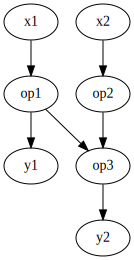

In [20]:
visualize_dag(dag)

In [22]:
forward_order = topological_sort(dag)
for node in forward_order:
    print(node.name)

x1
x2
op1
op2
y1
op3
y2


In [23]:
backward_order = list(reversed(forward_order))
for node in backward_order:
    print(node.name)

y2
op3
y1
op2
op1
x2
x1


### argmax/argmin：不可微

In [13]:
x = torch.randn(5, requires_grad=True)
x

tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229], requires_grad=True)

In [19]:
x

tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229], requires_grad=True)

In [21]:
torch.argmin(x)

tensor(4)

In [22]:
y = torch.argmax(x)
y.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

### topk (看似不可微，实则可微)

In [14]:
values, indices = torch.topk(x, 3)
values

tensor([0.3367, 0.2345, 0.2303], grad_fn=<TopkBackward0>)

In [15]:
values[0].backward(retain_graph=True)

In [16]:
x.grad

tensor([1., 0., 0., 0., 0.])

In [17]:
values[1].backward()

In [18]:
x.grad

tensor([1., 0., 1., 0., 0.])

In [42]:
x = torch.randn(5, requires_grad=True)
x

tensor([-0.1863,  2.2082, -0.6380,  0.4617,  0.2674], requires_grad=True)

In [47]:
y = torch.where(x > 0, torch.tensor(1., requires_grad=True), torch.tensor(0., requires_grad=True))
y

tensor([0., 1., 0., 1., 1.], grad_fn=<WhereBackward0>)

In [48]:
y.sum().backward()

In [49]:
x.grad

In [51]:
y = torch.where(x > 0, torch.tensor(1., requires_grad=True), torch.tensor(0., requires_grad=True))
y[0].backward()

In [52]:
x.grad